In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data_path = './data/'
model_path = './model/'
source_data_path = './data/MSBD5002PROJECT_data/'

## 1. Load Air Quality Data (on hourly basis)  
The Air Quality Data file contains the concentration of PM2.5 (ug/m3), PM10 (ug/m3), NO2 (ug/m3),
CO (mg/m3), O3 (ug/m3) and SO2 (ug/m3) from Beijing. Your group only need to predict the
concentration of PM2.5, PM10 and O3.

1). airQuality_201701-201801.csv &emsp; January 2017 to January 2018  
2). airQuality_201802-201803.csv &emsp; From February 2018 to March 2018  
3). airQuality_201804.csv &emsp; &emsp; &emsp; &emsp; April 2018

In [2]:
## Read Data
AQ_Jan = pd.read_csv(source_data_path+'airQuality_201701-201801.csv')
AQ_Mar = pd.read_csv(source_data_path+'airQuality_201802-201803.csv')
AQ_Apr = pd.read_csv(source_data_path+'airQuality_201804.csv',index_col=0)

Before we combined the three datasets, check all columns' names are same.

In [3]:
del AQ_Apr.index.name

In [4]:
AQ_Jan.rename(columns={'utc_time':'time'}, inplace=True)
AQ_Mar.rename(columns={'utc_time':'time'}, inplace=True)
AQ_Apr.rename(columns={'station_id':'stationId',\
                       'PM25_Concentration':'PM2.5','PM10_Concentration':'PM10',\
                       'NO2_Concentration':'NO2', 'CO_Concentration':'CO',\
                       'O3_Concentration':'O3','SO2_Concentration':'SO2'}, inplace=True)

In [5]:
print(AQ_Jan.columns)
print(AQ_Mar.columns)
print(AQ_Apr.columns)

Index(['stationId', 'time', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2'], dtype='object')
Index(['stationId', 'time', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2'], dtype='object')
Index(['stationId', 'time', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2'], dtype='object')


In [6]:
print(AQ_Jan.time.min())
print(AQ_Jan.time.max())
print(AQ_Mar.time.min())
print(AQ_Mar.time.max())
print(AQ_Apr.time.min())
print(AQ_Apr.time.max())

2017-01-01 14:00:00
2018-01-31 15:00:00
2018-01-31 16:00:00
2018-03-31 15:00:00
2018-04-01 02:00:00
2018-04-30 23:00:00


In [7]:
# All stations in AQ_Jan and AQ_Mar and AQ_Apr are the same. 
print(set(AQ_Jan.stationId.unique()) ^ set(AQ_Mar.stationId.unique()))
print(set(AQ_Jan.stationId.unique()) ^ set(AQ_Apr.stationId.unique()))

set()
set()


## 2.1 PreProcess AQ_Jan(Drop Duplicated rows).

Preprocessed air quality data firstly. There are 35 air quality stations who recorded pollutant concentrations from 2pm, Jan 1st, 2017 to 3pm, Jan 31th, 2018, with missed data. So we tried to find out missing values.

In [8]:
AQ_Jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311010 entries, 0 to 311009
Data columns (total 8 columns):
stationId    311010 non-null object
time         311010 non-null object
PM2.5        290621 non-null float64
PM10         227747 non-null float64
NO2          292359 non-null float64
CO           268197 non-null float64
O3           290589 non-null float64
SO2          292462 non-null float64
dtypes: float64(6), object(2)
memory usage: 19.0+ MB


In [9]:
print('Count of Stations: {0}'.format(len(AQ_Jan.stationId.unique())))
print('Count of TimeStamp(Hours): {0}'.format(len(AQ_Jan.time.unique())))
# 35 x 8701 = 304535, But number of rows is 311010.

Count of Stations: 35
Count of TimeStamp(Hours): 8701


Calculate the number of duplicated rows.

In [10]:
counter = 0
duplicated_column = pd.DataFrame(columns=AQ_Jan.columns.tolist())
for i, value in enumerate(AQ_Jan.duplicated()):
    if value:
        duplicated_column.loc[counter] = AQ_Jan.loc[i]
        counter += 1
counter

6475

In [11]:
# drop duplicated row in AQ_Jan
AQ_Jan = AQ_Jan.drop_duplicates()
AQ_Jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304535 entries, 0 to 311009
Data columns (total 8 columns):
stationId    304535 non-null object
time         304535 non-null object
PM2.5        284771 non-null float64
PM10         222667 non-null float64
NO2          286480 non-null float64
CO           262301 non-null float64
O3           284701 non-null float64
SO2          286575 non-null float64
dtypes: float64(6), object(2)
memory usage: 20.9+ MB


## 2.2 Combine all data together.

In [76]:
air_quality = pd.concat([AQ_Jan, AQ_Mar, AQ_Apr], ignore_index=True)

Sort "air_quality" by stationId and time.

In [77]:
air_quality = air_quality.sort_values(by=['stationId','time'])
air_quality = air_quality.reset_index(drop=True)

Drop columns 'CO','NO2','SO2'

In [78]:
air_quality = air_quality.drop(columns=['CO','NO2','SO2'],axis=1)

## 2.3 Find Outlier values(only consider PM2.5, PM10, O3)

In [143]:
Pollutants = air_quality.columns[2:5].tolist()
Stations = air_quality.stationId.unique()

In [16]:
def get_stat(df, attr):
    max_ = df[[attr]].max()
    min_ = df[[attr]].min()
    median_ = df[[attr]].median()
    mean_ = df[[attr]].mean()
    return np.hstack((max_, min_, median_, mean_))

In [19]:
for pollutant in Pollutants:
    pollutant_stat = get_stat(air_quality, pollutant)
    print('The statistical information of {0} is :\n\tMax: {1}\tMin: {2}\tMedian: {3}\tMean: {4}'\
          .format(pollutant, \
                  str(pollutant_stat[0]), str(pollutant_stat[1]), 
                  str(pollutant_stat[2]), str(pollutant_stat[3])))

The statistical information of PM2.5 is :
	Max: 1574.0	Min: 2.0	Median: 40.0	Mean: 61.285504365847856
The statistical information of PM10 is :
	Max: 3280.0	Min: 5.0	Median: 73.0	Mean: 93.87728746397694
The statistical information of O3 is :
	Max: 504.0	Min: 1.0	Median: 48.0	Mean: 56.53468696164657


#### Load pyecharts into Notebook
1. Make sure you have nodeJs on your laptop.
2. npm install -g phantomjs-prebuilt
3. pip install pyecharts-snapshot
4. pip install pyecharts

In [79]:
from pyecharts import Scatter
scatter = Scatter("Scatter Plot: Find outlier values",
                  width=1200,height=600)
for pollutant in Pollutants:
    scatter.add(pollutant,
                air_quality[pollutant].dropna().index,
                air_quality[pollutant].dropna().values.flatten(),
                is_datazoom_show=True,
                datazoom_orient='vertical',
                datazoom_range=[80,100],
                legend_top='30',
                mark_line="average",
                legend_selectedmode='single',
                is_toolbox_show=False
               )
scatter.render('./image/Outliers.html')

Outliers of PM2.5

In [24]:
air_quality[air_quality['PM2.5']>1000]

,stationId,time,PM2.5,PM10,O3
139411,huairou_aq,2018-03-29 14:00:00,1574.0,NaN,60.0
347640,yufa_aq,2017-05-05 02:00:00,1004.0,NaN,99.0
347641,yufa_aq,2017-05-05 03:00:00,1004.0,NaN,86.0


In [56]:
# air_quality.iloc[139411,2]=np.nan

Outliers of O3

In [40]:
air_quality[air_quality['O3']>=460]

,stationId,time,PM2.5,PM10,O3
14629,badaling_aq,2017-07-12 08:00:00,140.0,214.0,474.0
15117,badaling_aq,2017-08-01 23:00:00,30.0,NaN,500.0
33220,daxing_aq,2017-02-09 20:00:00,3.0,13.0,500.0
33316,daxing_aq,2017-02-13 20:00:00,134.0,146.0,500.0
33412,daxing_aq,2017-02-17 20:00:00,140.0,156.0,500.0
33457,daxing_aq,2017-02-19 20:00:00,5.0,25.0,500.0
33590,daxing_aq,2017-02-25 20:00:00,19.0,41.0,500.0
44639,dingling_aq,2017-03-09 12:00:00,6.0,23.0,500.0
44719,dingling_aq,2017-03-17 00:00:00,113.0,172.0,500.0
44771,dingling_aq,2017-03-19 04:00:00,250.0,NaN,500.0


In [57]:
# air_quality.iloc[253686,4]=np.nan
# air_quality.iloc[86597, 4]=np.nan
# air_quality.iloc[15117, 4]=np.nan

## 2.4 Find missed data for each station. 

In [58]:
print(air_quality.time.min())
print(air_quality.time.max())

2017-01-01 14:00:00
2018-04-30 23:00:00


In [139]:
import datetime
from operator import itemgetter
from itertools import groupby

In [145]:
def stat_missing_data(air_quality, Stations, Pollutants, timeFrom='2017-01-01 14:00:00', timeTo='2018-04-30 23:00:00'):
    timeFrom = datetime.datetime.strptime(timeFrom, "%Y-%m-%d %H:%M:%S")
    timeTo = datetime.datetime.strptime(timeTo, "%Y-%m-%d %H:%M:%S")
    Hours_Delta = pd.date_range(timeFrom, timeTo, freq='H').strftime('%Y-%m-%d %H:%M:%S')
    Times_missed = {}
    for station in Stations:
        Times_missed[station] = {}
        # Find time not in rows.
        tmp = air_quality[air_quality['stationId']==station].time.unique()
        tmp = list(set(Hours_Delta) - set(tmp))
        # In a Station, find time of row with missing pollutant concentation values.
        for pollutant in Pollutants:
            tmp_nan = air_quality[(air_quality['stationId']==station) & \
                                  (air_quality[pollutant].isnull())].time.unique()     
            Times_missed[station][pollutant] = np.concatenate((tmp,tmp_nan))
    
    # Built a dataframe to record numbers of continuous missing hours for a station. 
    lost_hour_record = pd.DataFrame(columns=['stationId', 'pollutant', 'start_time', 'counts'])
    for station in Stations:
        for pollutant in Pollutants:
            tmp = [(i, int(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timestamp()/3600)) \
                   for i,x in enumerate(sorted(Times_missed[station][pollutant]))]
            for key, group in groupby(tmp, lambda x: x[0]-x[1]):
                group = list(group)
                lost_hours = len(group)
                start_hour = datetime.datetime.fromtimestamp(group[0][1]*3600).strftime('%Y-%m-%d %H:%M:%S')
                row_num = len(lost_hour_record.index)
                lost_hour_record.loc[row_num] = [station, pollutant, start_hour, lost_hours]
    return lost_hour_record

In [38]:
lost_hour_record = stat_missing_data(air_quality, Stations, Pollutants)
# lost_hour_record.to_csv(data_path+'lost_hour_record.csv',index=None)
lost_hour_record = pd.read_csv(data_path+'lost_hour_record.csv')

**Plot missing data distribution.(PM2.5)**

<Figure size 432x288 with 0 Axes>

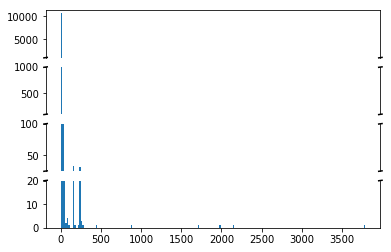

In [65]:
tmp = lost_hour_record[lost_hour_record['pollutant']=='PM2.5'].counts

plt.tight_layout()

fig, axs = plt.subplots(4, 1, sharex=True)

# plot the same data on both axes
for i in range(4):
    axs[i].hist(tmp, bins=200)
    
# # zoom-in / limit the view to different portions of the data
axs[0].set_ylim(bottom=1000)
axs[1].set_ylim(bottom=100, top=1000)  
axs[2].set_ylim(bottom=25, top=100)
axs[3].set_ylim(bottom=0,top=20)
axs[0].spines['bottom'].set_visible(False)
axs[3].spines['top'].set_visible(False)
axs[0].xaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[2].xaxis.set_visible(False)

d = .005  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
axs[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axs[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

for i in range(1,3):
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    
    kwargs.update(transform=axs[i].transAxes)
    axs[i].plot((-d, +d), (-d, +d), **kwargs)
    axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
    axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)
    axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=axs[3].transAxes)  # switch to the bottom axes
axs[3].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axs[3].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

In [66]:
def func1(lost_hour_record, pollutant='PM2.5'):
    return lost_hour_record[lost_hour_record['pollutant']==pollutant].groupby(['counts']).size()

In [75]:
from pyecharts import Bar
bar = Bar("Distribution: Counts of continuous missed hours rows",
          'eg:PM2.5 1:6570 指PM2.5连续缺失1小时数据的情况出现6570次'
         )
for pollutant in Pollutants:
    bar.add(pollutant,
            func1(lost_hour_record, pollutant).index,
            func1(lost_hour_record, pollutant).values, 
            legend_top='30',
            legend_pos='right',
            is_stack=True,
            # default is X axis，horizontal
            is_datazoom_show=True,
            datazoom_type="slider",
            datazoom_range=[0, 50],
            is_toolbox_show=False,
            xaxis_name='Counts of continuous missed hours',
            yaxis_name='Times',
            yaxis_name_gap=60,
            legend_selectedmode='single'
           )
bar.render('./image/lost_record.html')

## 2.5 Fill missing values(only consider PM2.5, PM10, O3)

### A. Add rows with lost hours for each station.

In [69]:
# add lose time data rows
for station in Stations:
    tmp = air_quality[air_quality['stationId']==station].time.unique()
    tmp = list(set(Hours_Delta) - set(tmp))
    tmp_df = pd.DataFrame(tmp, columns=['time'])
    tmp_df['stationId'] = station
    for pollutant in Pollutants:
        tmp_df[pollutant] = np.nan
    tmp_df = tmp_df[air_quality.columns]
    air_quality = pd.concat([air_quality, tmp_df], ignore_index=True)

In [3]:
# air_quality = air_quality.sort_values(by=['stationId','time'])
# air_quality = air_quality.reset_index(drop=True)
# air_quality.to_csv(data_path+'air_quality.csv',index=None)
air_quality = pd.read_csv(data_path+'air_quality.csv')

url: https://stackoverflow.com/questions/24870953/does-iterrows-have-performance-issues  
Generally, iterrows should only be used in very very specific cases. This is the general order of precedence for performance of various operations:  
1) vectorization  
2) using a custom cython routine  
3) apply:  a) reductions that can be performed in cython  b) iteration in python space  
4) itertuples  
5) iterrows  
6) updating an empty frame (e.g. using loc one-row-at-a-time)  
  
Using a custom cython routine is usually too complicated, so let's skip that for now.    
1) Vectorization is ALWAYS ALWAYS the first and best choice. However, there are a small set of cases which cannot be vectorized in obvious ways (mostly involving a recurrence). Further, on a smallish frame, it may be faster to do other methods.  
3) Apply involves can usually be done by an iterator in Cython space (this is done internally in pandas) (this is a) case.  
This is dependent on what is going on inside the apply expression. e.g. df.apply(lambda x: np.sum(x)) will be executed pretty swiftly (of course df.sum(1) is even better). However something like: df.apply(lambda x: x['b'] + 1) will be executed in python space, and consequently is slower.    
4) itertuples does not box the data into a Series, just returns it as a tuple  
5) iterrows DOES box the data into a Series. Unless you really need this, use another method  
6) updating an empty frame a-single-row-at-a-time. I have seen this method used WAY too much. It is by far the slowest. It is probably common place (and reasonably fast for some python structures), but a DataFrame does a fair number of checks on indexing, so this will always be very slow to update a row at a time. Much better to create new structures and concat.

### B. For lost values within continuous hours of three, we fill them with the adjacent values.**

In [29]:
# DataFrame.interpolate(method='linear', axis=0, limit=None, inplace=False,\
#                       limit_direction='forward', limit_area=None, downcast=None, **kwargs)[source]

# It took long time...
# map pullutants and columns in air quality dataframe.
pollutant_map = {'PM2.5': 2, 'PM10': 3, 'O3': 4}
threshold=3
def fill_nan_data(row):
    
        station_sindex = air_quality[(air_quality['stationId']==row['stationId']) & \
                                     (air_quality['time']=='2017-01-01 14:00:00')].index[0]
        station_eindex = air_quality[(air_quality['stationId']==row['stationId']) & \
                                     (air_quality['time']=='2018-04-30 23:00:00')].index[0]
        start_index = air_quality[(air_quality['stationId']==row['stationId']) & \
                                  (air_quality['time']==row['start_time'])].index[0]-1
        end_index = start_index + 1 + row['counts']
        
        if start_index >= station_sindex and end_index <= station_eindex:
            p_index = pollutant_map[row['pollutant']]
            interval = air_quality.iloc[end_index, p_index] - air_quality.iloc[start_index, p_index]
            s_concentration = air_quality.iloc[start_index, p_index]
            time_counts = row['counts'] + 1
            for i in range(start_index+1, end_index):
                if interval == 0:
                    air_quality.iloc[i, p_index] = s_concentration
                else:
                    air_quality.iloc[i, p_index] = s_concentration + interval/time_counts*(i-start_index)

lost_hour_record[lost_hour_record.counts<=threshold].apply(lambda row: fill_nan_data(row), axis=1)

0        None
1        None
2        None
3        None
4        None
5        None
6        None
8        None
9        None
11       None
12       None
14       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
25       None
26       None
29       None
30       None
31       None
32       None
33       None
34       None
35       None
36       None
         ... 
50231    None
50232    None
50233    None
50234    None
50235    None
50236    None
50237    None
50238    None
50239    None
50240    None
50241    None
50242    None
50243    None
50245    None
50246    None
50247    None
50248    None
50249    None
50250    None
50251    None
50252    None
50253    None
50254    None
50255    None
50256    None
50257    None
50258    None
50259    None
50260    None
50261    None
Length: 40631, dtype: object

In [4]:
stations = pd.read_csv(data_path+'air_quality_station_info.csv',index_col=0)
time_info = pd.read_csv(data_path+'time_info.csv',index_col=0)

In [25]:
columns_new = air_quality.columns.append(time_info.columns[2:])
air_quality = air_quality.merge(time_info,on='time',how='left')[columns_new]

### C.For the rest of lossing values, we consider pretrain a model of a pollutant to fill them.

In [28]:
air_quality.corr()

,PM2.5,PM10,O3,year,month,day,weekday,hour
PM2.5,1.000000,0.742676,-0.114345,0.012630,-0.140430,-0.047541,0.003905,0.019917
PM10,0.742676,1.000000,-0.014273,0.064326,-0.097578,-0.015307,0.017391,0.007086
O3,-0.114345,-0.014273,1.000000,-0.023517,-0.041284,0.005326,-0.014551,-0.250273
year,0.012630,0.064326,-0.023517,1.000000,-0.497294,-0.010794,-0.006125,-0.000499
month,-0.140430,-0.097578,-0.041284,-0.497294,1.000000,0.010925,0.018513,-0.001126
day,-0.047541,-0.015307,0.005326,-0.010794,0.010925,1.000000,-0.007794,-0.001458
weekday,0.003905,0.017391,-0.014551,-0.006125,0.018513,-0.007794,1.000000,0.001304
hour,0.019917,0.007086,-0.250273,-0.000499,-0.001126,-0.001458,0.001304,1.000000


#### Build pretrain model
Use last three days(72 hours) datas as features.

In [15]:
def build_train_data(air_quality, length=24*3):
    attr = ['PM2.5','PM10','O3','weekday','hour']
    train_data = []
    for station in Stations:
        station_data = air_quality[air_quality.stationId==station].sort_values(by='time')
        station_data = station_data[attr].values
        for i in range(0, station_data.shape[0]-length):
            # Prepare a line of training dataset.
            # Features = stationId, stationType, Weekday, Hour
            row = [station, stations[stations.stationId==station].station_type.values[0],\
                   station_data[i+length,-2], station_data[i+length,-1]]
            history_data = station_data[i:i+length,:3].T.flatten().tolist()
            target_data = station_data[i+length,:3].flatten().tolist()
            row += history_data + target_data
            if pd.isna(row).sum() == 0:
                train_data.append(row)
    return train_data
train_data = build_train_data(air_quality, 72)

In [17]:
len(train_data)

131692

In [19]:
# Using numpy.save_file met an error. So use another function from package of csv.b
import csv

with open(data_path+"air_quality_pretrain_data.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(train_data)

In [17]:
def get_statfeatures(narray, pollutant='PM2.5', d='H'):
    '''get_statfeatures(narray, d='H')
    Since features of three pollutants are the same, which is not suitable to train three models, 
    we added another statistical feature for perticular pollutant.
    narray: air_quality[:, 4:4+72], namely history data of a perticular pollutant.
    '''
    if d=='H':
        # compute last 72 hours data. (Return 5 features)
        max_ = np.max(narray, axis=1)
        min_ = np.min(narray, axis=1)
        mean_ = np.mean(narray, axis=1)
        median_ = np.median(narray, axis=1)
        var_ = np.var(narray, axis=1)
        return np.hstack((mean_, median_, max_, min_, var_)).reshape(-1,5)
    elif d=='D':
        # In last 3 day, compute every day's data. (Return 3*5 features)
        stat_outcome = np.array([[] for i in range(narray.shape[0])])
        for i in range(int(narray.shape[1]/24)):
            stat_day = get_statfeatures(narray[:,i*24:(i+1)*24], d='H')
            stat_outcome = np.hstack((stat_outcome, stat_day))
        return stat_outcome


def get_onehot(narray, stationType_map, stationId_map):
    '''get_onehot(narray)
    Format four features: stationId(35), stationType(4), weekday(7), hour(24) into seventy bool-typed features.
    narray: air_quality[:,:4], namely all four features of training data 
    '''
    onehot_data = []
    for i in range(narray.shape[0]):
        onehot_row = np.zeros(70)
        # stationId
        onehot_row[stationId_map[narray[i,0]]] = 1
        # stationType
        onehot_row[35+stationType_map[narray[i,1]]] = 1
        # weekday
        onehot_row[39+int(narray[i,2])] = 1
        # hour
        onehot_row[46+int(narray[i,3])] = 1
        
        onehot_data.append(onehot_row)
    return np.array(onehot_data)


def build_features(train_data, stations, pollutant='PM2.5', length=24*3):
    '''
    train_data: source pre-train data.
    stations: information of each station, a dataframe.
    '''
    if pollutant == 'PM2.5':
        static_hour = get_statfeatures(train_data[:,4:4+length], d='H')
        static_days = get_statfeatures(train_data[:,4:4+length], d='D')
    elif pollutant == 'PM10':
        static_hour = get_statfeatures(train_data[:, 4+length:4+length*2], d='H')
        static_days = get_statfeatures(train_data[:,4+length:4+length*2], d='D')
    else:
        static_hour = get_statfeatures(train_data[:, 4+length*2:4+length*3], d='H')
        static_days = get_statfeatures(train_data[:,4+length*2:4+length*3], d='D')
        
    stationId_map = {}
    for index, station in enumerate(sorted(stations.stationId.unique().tolist())):
        stationId_map[station] = index
    stationType_map = {}
    for index, stationtype in enumerate(stations.station_type.unique().tolist()):
        stationType_map[stationtype] = index
        
    onehot = get_onehot(train_data[:,:4], stationType_map, stationId_map)
    
    return np.hstack((onehot, train_data[:,4:-3], static_hour, static_days))

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [21]:
def built_model(train_data, stations, pollutant='PM2.5', length=24*3):
    if pollutant == 'PM2.5':
        dataset_Y = train_data[:,-3]
    elif pollutant == 'PM10':
        dataset_Y = train_data[:,-2]
    else:
        dataset_Y = train_data[:,-1]   
    dataset_X = build_features(train_data, stations, pollutant, length)
    train_X, test_X, train_Y, test_Y = train_test_split(dataset_X, dataset_Y, test_size=0.2, random_state=10)
    
    # load regression model
    reg = xgb.XGBRegressor()
    reg.fit(train_X, train_Y)
    
    # validation
    pred_Y = reg.predict(test_X)
    validation_error = np.mean(np.abs(pred_Y - test_Y) / (pred_Y + test_Y) * 2)
    print('Validation error of {0} is {1}'.format(pollutant, str(validation_error)))
    
    model_file = model_path + pollutant + '_fillmissingdata.model'
    joblib.dump(reg, model_file)
    return reg

In [ ]:
# Run this cell on Colab.

reg_PM25 = built_model(train_data, stations, 'PM2.5')
# Validation error of PM2.5 is 0.21988583652019708

reg_PM10 = built_model(train_data, stations, 'PM10')
# Validation error of PM10 is 0.19306589695892443

reg_O3 = built_model(train_data, stations, 'O3')
# Validation error of O3 is 0.2787606643604839

Since we have to use past three days air quality concentraction to predict current AQI, we have to make sure that the first three days' data are not nan.

In [44]:
def firstdays_miss(air_quality, pollutant='PM2.5', threshold=3*24):
    start_time = datetime.datetime.strptime('2017-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")
    end_time = start_time + datetime.timedelta(hours=threshold)
    end_time = datetime.datetime.strftime(end_time, "%Y-%m-%d %H:%M:%S")
    counts = air_quality[(air_quality['time']<end_time)& \
                         (air_quality[pollutant].isna())].shape[0]
    print('Number of missing values of {0} in first {1} days:\t {2}'.format(pollutant, str(threshold/24), counts))
firstdays_miss(air_quality, 'PM2.5')
firstdays_miss(air_quality, 'PM10')
firstdays_miss(air_quality, 'O3')

Number of missing values of PM2.5 in first 3.0 days:	 15
Number of missing values of PM10 in first 3.0 days:	 1124
Number of missing values of O3 in first 3.0 days:	 12


1. PM2.5

In [156]:
lost_hour_record[(lost_hour_record['pollutant']=='PM2.5') & \
                 (lost_hour_record['counts']>3) & \
                 (lost_hour_record['start_time']<='2017-01-04 14:00:00')]

,stationId,pollutant,start_time,counts
14000,guanyuan_aq,PM2.5,2017-01-03 09:00:00,22


Using average pollutant concentration of same hour in same weekday in recent two months to fill missing data in first three days.

In [174]:
from dateutil.relativedelta import relativedelta
def fill_firstdays(air_quality, pollutant, threshold=24*3, accordingto=2):
    start_time = datetime.datetime.strptime('2017-01-01 14:00:00', "%Y-%m-%d %H:%M:%S")
    end_time = start_time + datetime.timedelta(hours=threshold)
    end_time = datetime.datetime.strftime(end_time, "%Y-%m-%d %H:%M:%S")
    # Find missing pollutant air quality's index in first 3 days.
    missing_index = air_quality[(air_quality['time']<end_time)&\
                                (air_quality[pollutant].isna())].index
    pollutant_map = {'PM2.5':2, 'PM10':3, 'O3':4}
    for index in missing_index:
        cur_station = air_quality.loc[index,'stationId']
        cur_time = air_quality.loc[index,'time']
        cur_weekday = air_quality.loc[index,'weekday']
        cur_hour = air_quality.loc[index,'hour']
        # find reference data
        refer_period = accordingto
        while True:
            time_period = datetime.datetime.strptime(cur_time, "%Y-%m-%d %H:%M:%S") + relativedelta(months=refer_period)
            time_period = datetime.datetime.strftime(time_period, "%Y-%m-%d %H:%M:%S")              
            reference_data = air_quality[(air_quality['stationId']==cur_station)&\
                                         (air_quality['time'] > cur_time)&\
                                         (air_quality['time'] <= time_period)&\
                                         (air_quality['weekday'] == cur_weekday)&\
                                         (air_quality['hour'] == cur_hour)][pollutant].values
            reference_data = [x for x in reference_data if str(x) != 'nan']
            if len(reference_data) == 0:
                # if in the next two months, reference data is all nan, add one months data to reference 
                refer_period += 1
                continue
            air_quality.iloc[index, pollutant_map[pollutant]] = np.mean(reference_data)
            # print(reference_data)
            break

In [ ]:
fill_firstdays(air_quality, 'PM2.5')

In [158]:
start_time = datetime.datetime.strptime('2017-01-01 14:00:00', "%Y-%m-%d %H:%M:%S")
end_time = start_time + datetime.timedelta(hours=72)
datetime.datetime.strftime(end_time, "%Y-%m-%d %H:%M:%S")

'2017-01-04 14:00:00'

2. PM10

In [161]:
lost_hour_record[(lost_hour_record['pollutant']=='PM10') & \
                 (lost_hour_record['counts']>3) & \
                 (lost_hour_record['start_time']<='2017-01-04 14:00:00')]

,stationId,pollutant,start_time,counts
253,aotizhongxin_aq,PM10,2017-01-01 19:00:00,9
255,aotizhongxin_aq,PM10,2017-01-02 07:00:00,25
260,aotizhongxin_aq,PM10,2017-01-04 03:00:00,4
261,aotizhongxin_aq,PM10,2017-01-04 08:00:00,13
3064,beibuxinqu_aq,PM10,2017-01-01 16:00:00,38
3067,beibuxinqu_aq,PM10,2017-01-03 14:00:00,19
4561,daxing_aq,PM10,2017-01-01 20:00:00,4
4562,daxing_aq,PM10,2017-01-02 02:00:00,8
4569,daxing_aq,PM10,2017-01-04 13:00:00,10
5788,dingling_aq,PM10,2017-01-01 15:00:00,15


Using average pollutant concentration of same hour in same weekday in recent two months to fill missing data in first three days.

In [172]:
fill_firstdays(air_quality, 'PM10')

3. O3

In [163]:
lost_hour_record[(lost_hour_record['pollutant']=='O3') & \
                 (lost_hour_record['counts']>3) & \
                 (lost_hour_record['start_time']<='2017-01-04 14:00:00')]

,stationId,pollutant,start_time,counts
9599,dongsi_aq,O3,2017-01-04 06:00:00,4
14976,guanyuan_aq,O3,2017-01-03 08:00:00,6
14977,guanyuan_aq,O3,2017-01-04 03:00:00,4
38502,wanshouxigong_aq,O3,2017-01-04 06:00:00,23
42791,yizhuang_aq,O3,2017-01-03 05:00:00,6


Since the missing values of O3 in first three days is not so intensive, we directly fill them with adjacent values.

In [70]:
a = air_quality[(air_quality['stationId']=='yizhuang_aq') &\
                (air_quality['time']>='2017-01-03 04:00:00') &\
                (air_quality['time']<='2017-01-03 11:00:00')]['O3']
air_quality.iloc[a.index,4] = a.interpolate()

In [71]:
b = air_quality[(air_quality['stationId']=='guanyuan_aq') &\
                (air_quality['time']>='2017-01-03 07:00:00') &\
                (air_quality['time']<='2017-01-03 14:00:00')]['O3']
air_quality.iloc[b.index,4] = b.interpolate()

In [164]:
c = air_quality[(air_quality['stationId']=='guanyuan_aq') &\
                (air_quality['time']>='2017-01-04 02:00:00') &\
                (air_quality['time']<='2017-01-04 07:00:00')]['O3']
air_quality.iloc[c.index,4] = c.interpolate()

In [165]:
d = air_quality[(air_quality['stationId']=='dongsi_aq') &\
                (air_quality['time']>='2017-01-04 05:00:00') &\
                (air_quality['time']<='2017-01-04 10:00:00')]['O3']
air_quality.iloc[d.index,4] = d.interpolate()

In [178]:
fill_firstdays(air_quality, 'O3')

**Hence, the first three days data is all filled!**

In [179]:
air_quality[(air_quality['time']<'2017-01-04 14:00:00') &\
            ((air_quality['PM2.5'].isna()) |\
             (air_quality['PM10'].isna()) |\
             (air_quality['O3'].isna()))]

,stationId,time,PM2.5,PM10,O3,year,month,day,weekday,hour


In [180]:
air_quality.to_csv(data_path+'air_quality_fillthree.csv')
# air_quality = pd.read_csv(data_path+'air_quality_fillthree.csv',index_col=0)

#### Use trained model to fill missing values.

In [181]:
# Compute lost_hour_record again.
new_lost_hour_record = stat_missing_data(air_quality, Stations, Pollutants)

In [182]:
# zhiwuyuan_aq 2017-11-24 03:00:00 all three pollutants missed 3789 records.
new_lost_hour_record[(new_lost_hour_record['stationId']=='zhiwuyuan_aq') &\
                     (new_lost_hour_record['pollutant']=='PM2.5')]

,stationId,pollutant,start_time,counts
9272,zhiwuyuan_aq,PM2.5,2017-01-06 13:00:00,7
9273,zhiwuyuan_aq,PM2.5,2017-01-06 22:00:00,8
9274,zhiwuyuan_aq,PM2.5,2017-01-08 15:00:00,6
9275,zhiwuyuan_aq,PM2.5,2017-01-09 14:00:00,20
9276,zhiwuyuan_aq,PM2.5,2017-01-10 16:00:00,10
9277,zhiwuyuan_aq,PM2.5,2017-01-11 13:00:00,21
9278,zhiwuyuan_aq,PM2.5,2017-01-17 08:00:00,4
9279,zhiwuyuan_aq,PM2.5,2017-01-18 08:00:00,7
9280,zhiwuyuan_aq,PM2.5,2017-01-24 08:00:00,12
9281,zhiwuyuan_aq,PM2.5,2017-01-25 13:00:00,7


In [183]:
def get_onehot_row(narray, stationType_map, stationId_map):
    onehot_row = np.zeros(70)
    # stationId
    onehot_row[stationId_map[narray[0]]] = 1
    # stationType
    onehot_row[35+stationType_map[narray[1]]] = 1
    # weekday
    onehot_row[39+int(narray[2])] = 1
    # hour
    onehot_row[46+int(narray[3])] = 1
        
    return onehot_row

def get_statfeatures_row(narray, pollutant='PM2.5', d='H'):
    if d=='H':
        # compute last 72 hours data. (Return 5 features)
        max_ = np.max(narray)
        min_ = np.min(narray)
        mean_ = np.mean(narray)
        median_ = np.median(narray)
        var_ = np.var(narray)
        return np.hstack((mean_, median_, max_, min_, var_))
    elif d=='D':
        # In last 3 day, compute every day's data. (Return 3*5 features)
        stat_outcome = np.array([])
        for i in range(int(len(narray)/24)):
            stat_day = get_statfeatures_row(narray[i*24:(i+1)*24], d='H')
            stat_outcome = np.hstack((stat_outcome, stat_day))
        return stat_outcome
    
def build_features_row(train_data, stations, pollutant='PM2.5', length=24*3):
    if pollutant == 'PM2.5':
        static_hour = get_statfeatures_row(train_data[4:4+length], d='H')
        static_days = get_statfeatures_row(train_data[4:4+length], d='D')
    elif pollutant == 'PM10':
        static_hour = get_statfeatures_row(train_data[4+length:4+length*2], d='H')
        static_days = get_statfeatures_row(train_data[4+length:4+length*2], d='D')
    else:
        static_hour = get_statfeatures_row(train_data[4+length*2:4+length*3], d='H')
        static_days = get_statfeatures_row(train_data[4+length*2:4+length*3], d='D')  
        
    onehot = get_onehot_row(train_data[:4], stationType_map, stationId_map)
    
    return np.hstack((onehot, train_data[4:], static_hour, static_days))

In [184]:
def predict_filldata(air_quality, stations, length=24*3):
    attr = ['PM2.5','PM10','O3','weekday','hour']
    
    smape_PM25_sum = 0
    count_PM25 = 0
    smape_PM10_sum = 0
    count_PM10 = 0
    smape_O3_sum = 0
    count_O3 = 0
    
    for station in stations.stationId.unique().tolist():
        station_index = air_quality[air_quality.stationId==station].index
        station_data = air_quality[air_quality.stationId==station]
        station_data = station_data[attr].values
        for i in range(0, station_data.shape[0]-length):
            # Prepare a line of testing dataset.
            # Features = stationId, stationType, Weekday, Hour
            station_data = air_quality[air_quality.stationId==station][attr].values
            row = [station, stations[stations.stationId==station].station_type.values[0],\
                   station_data[i+length,-2], station_data[i+length,-1]]
            history_data = station_data[i:i+length,:3].T.flatten().tolist()
            row += history_data 
            if pd.isna(history_data).sum() > 0:
                continue
                
            # PM2.5
            test_Y = station_data[i+length,0]
            test_X = build_features_row(row, stations, 'PM2.5', length)
            pred_Y = reg_PM25.predict([test_X])[0]
            if np.isnan(test_Y):
                air_quality.iloc[station_index[i+length],2] = pred_Y
            else:
                count_PM25 += 1
                smape_PM25_sum += np.abs(pred_Y - test_Y) / (pred_Y + test_Y) * 2
                
            # PM10
            test_Y = station_data[i+length,1]
            test_X = build_features_row(row, stations, 'PM10', length)
            pred_Y = reg_PM10.predict([test_X])[0]
            if np.isnan(test_Y):
                air_quality.iloc[station_index[i+length],3] = pred_Y
            else:
                count_PM10 += 1
                smape_PM10_sum += np.abs(pred_Y - test_Y) / (pred_Y + test_Y) * 2
                
            # O3
            test_Y = station_data[i+length,2]
            test_X = build_features_row(row, stations, 'O3', length)
            pred_Y = reg_O3.predict([test_X])[0]
            if np.isnan(test_Y):
                air_quality.iloc[station_index[i+length],4] = pred_Y
            else:
                count_O3 += 1
                smape_O3_sum += np.abs(pred_Y - test_Y) / (pred_Y + test_Y) * 2
    print('PM2.5: Test on {0} records, SMAPE is {1}'.format(str(count_PM25), str(smape_PM25_sum/count_PM25)))
    print('PM10: Test on {0} records, SMAPE is {1}'.format(str(count_PM10), str(smape_PM10_sum/count_PM10)))
    print('O3: Test on {0} records, SMAPE is {1}'.format(str(count_O3), str(smape_O3_sum/count_O3)))

In [ ]:
# run this code on colab
predict_filldata(air_quality, stations, length=24*3)
# PM2.5: Test on 363897 records, SMAPE is 0.217603987484511
# PM10: Test on 306011 records, SMAPE is 0.2186182912651704
# O3: Test on 365225 records, SMAPE is 0.27200874748285714

In [ ]:
air_quality.to_csv(data_path+'air_quality_final.csv')